In [1]:
import typing
import gc
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import matplotlib.pyplot as plt

In [7]:
synthetic_expression_data = pd.read_csv("data/net1_expression_data.tsv", sep='\t')
tfs = pd.read_csv("data/net1_transcription_factors.tsv", sep='\t')
X_bool = [g in tfs.iloc[:,0].tolist() for g in synthetic_expression_data.columns]
not_X = [not(e) for e in X_bool]
X_idx = [i for (i, e) in enumerate(X_bool) if e]

In [8]:
np.mean(synthetic_expression_data.iloc[:,5])

0.22875542161490708

In [9]:
# NORMALIZE
z_transform = StandardScaler(copy=False)
z_transform.fit_transform(synthetic_expression_data)

array([[-1.5135019 , -0.66290202,  1.03572236, ...,  0.80809829,
        -0.50382442,  0.31617673],
       [-1.45167419, -0.53050131,  0.8607514 , ...,  0.25232604,
         0.12795303, -0.28548304],
       [ 0.78925704,  0.10903195, -0.96012133, ..., -0.24248621,
         2.06034446, -0.38735928],
       ...,
       [-0.41204774, -0.71939937, -1.46065408, ..., -1.36395599,
         0.42436466, -1.38833964],
       [-0.03053673, -0.69172511,  0.682982  , ..., -0.38703482,
         0.29840991,  0.23433932],
       [-0.58072988, -0.73283357, -1.38487299, ..., -1.36066726,
         0.36135719, -1.49716293]])

In [10]:
np.mean(synthetic_expression_data.iloc[:,5])

-2.4273199047705285e-17

In [11]:
train, valid, test = (
    synthetic_expression_data.values[:500, :], 
    synthetic_expression_data.values[500:700, :],
    synthetic_expression_data.values[700:, :])

In [16]:
alphas = np.linspace(0.01, 0.25, num=20)
valid_losses = []
for alpha in alphas:
    print("Computing validation loss for alpha = {}".format(alpha))
    lasso_model = Lasso(alpha).fit(train[:, X_bool], train)
    Y_hat = lasso_model.predict(valid[:, X_bool])
    valid_losses.append(mean_squared_error(Y_hat, valid))

Computing validation loss for alpha = 0.01
Computing validation loss for alpha = 0.02263157894736842
Computing validation loss for alpha = 0.035263157894736843
Computing validation loss for alpha = 0.04789473684210526
Computing validation loss for alpha = 0.060526315789473685
Computing validation loss for alpha = 0.0731578947368421
Computing validation loss for alpha = 0.08578947368421051
Computing validation loss for alpha = 0.09842105263157894
Computing validation loss for alpha = 0.11105263157894736
Computing validation loss for alpha = 0.12368421052631579
Computing validation loss for alpha = 0.13631578947368422
Computing validation loss for alpha = 0.14894736842105263
Computing validation loss for alpha = 0.16157894736842104
Computing validation loss for alpha = 0.17421052631578948
Computing validation loss for alpha = 0.1868421052631579
Computing validation loss for alpha = 0.19947368421052633
Computing validation loss for alpha = 0.21210526315789474
Computing validation loss for

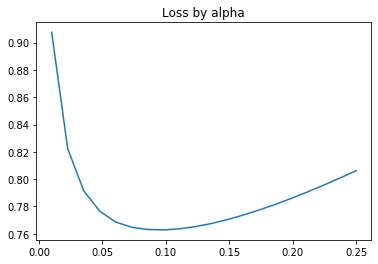

In [17]:
# plot losses
plt.plot(alphas, valid_losses)
plt.title("Loss by alpha")
plt.show()

In [18]:
lasso_model = Lasso(alphas[np.argmin(valid_losses)]).fit(train[:, X_bool], train)

Look at the model coefficients

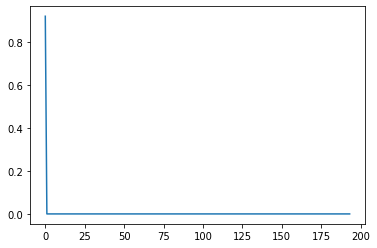

In [26]:
plt.plot(lasso_model.coef_[1])

In [27]:
Y_hat = lasso_model.predict(valid[:, X_bool])

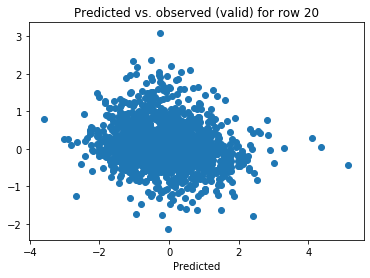

In [37]:
# plot predicted vs. observed for a random row
idx = np.random.randint(0, valid.shape[0])
plt.scatter(valid[idx], Y_hat[idx])
plt.xlabel("Observed")
plt.xlabel("Predicted")
plt.title("Predicted vs. observed (valid) for row {}".format(idx));

In [29]:
Y_hat = lasso_model.predict(test[:, X_bool])
print("Final test loss (mse): {}".format(mean_squared_error(Y_hat, test)))

Final test loss (mse): 0.8248402650510994


### Why is regularisation making performance poorer?
Is X compressible?

In [30]:
from sklearn.decomposition import PCA

In [31]:
pca_model = PCA().fit(train[:, X_bool])

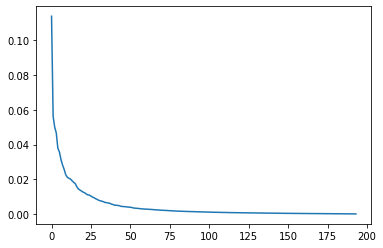

In [32]:
plt.plot(pca_model.explained_variance_ratio_)

In [38]:
# sanity check
sum(pca_model.explained_variance_ratio_)

1.0000000000000002

**Is all the information really in variable 0?**

In [39]:
lasso_model_2 = Lasso().fit(train[:, X_idx[0]].reshape(train.shape[0],1), train)

In [40]:
Y_hat = lasso_model_2.predict(valid[:, X_idx[0]].reshape(valid.shape[0],1))
print(mean_squared_error(Y_hat, valid))

1.0103218929960154


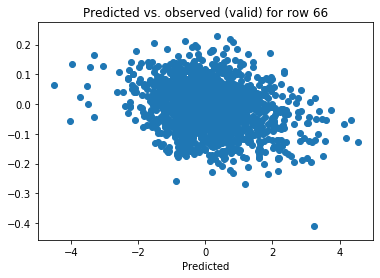

In [41]:
# plot predicted vs. observed for a random row
idx = np.random.randint(0, valid.shape[0])
plt.scatter(valid[idx], Y_hat[idx])
plt.xlabel("Observed")
plt.xlabel("Predicted")
plt.title("Predicted vs. observed (valid) for row {}".format(idx));

1.4450256383236184


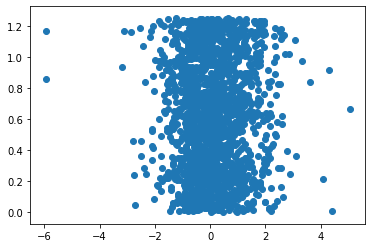

In [42]:
# what does random mse look like?
rand_pred = np.random.uniform(0, 1.25, size=valid.shape[1])
print(mean_squared_error(rand_pred, valid[0]))
plt.scatter(valid[0], rand_pred);

Let's try without variable 0

In [43]:
X_idx = X_idx[1:]

In [45]:
alphas = np.linspace(0.01, 0.25, num=20)
valid_losses = []
for alpha in alphas:
    print("Computing validation loss for alpha = {}".format(alpha))
    lasso_model = Lasso(alpha).fit(train[:, X_bool], train)
    Y_hat = lasso_model.predict(valid[:, X_bool])
    valid_losses.append(mean_squared_error(Y_hat, valid))

Computing validation loss for alpha = 0.01
Computing validation loss for alpha = 0.02263157894736842
Computing validation loss for alpha = 0.035263157894736843
Computing validation loss for alpha = 0.04789473684210526
Computing validation loss for alpha = 0.060526315789473685
Computing validation loss for alpha = 0.0731578947368421
Computing validation loss for alpha = 0.08578947368421051
Computing validation loss for alpha = 0.09842105263157894
Computing validation loss for alpha = 0.11105263157894736
Computing validation loss for alpha = 0.12368421052631579
Computing validation loss for alpha = 0.13631578947368422
Computing validation loss for alpha = 0.14894736842105263
Computing validation loss for alpha = 0.16157894736842104
Computing validation loss for alpha = 0.17421052631578948
Computing validation loss for alpha = 0.1868421052631579
Computing validation loss for alpha = 0.19947368421052633
Computing validation loss for alpha = 0.21210526315789474
Computing validation loss for

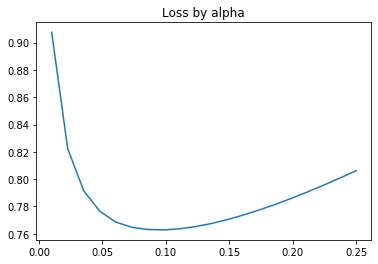

In [46]:
# plot losses
plt.plot(alphas, valid_losses)
plt.title("Loss by alpha")
plt.show()

In [47]:
print("Create a lasso model using alpha = {}".format(alphas[np.argmin(valid_losses)]))
lasso_model = Lasso(alphas[np.argmin(valid_losses)]).fit(train[:, X_idx], train)

Create a lasso model using alpha = 0.09842105263157894


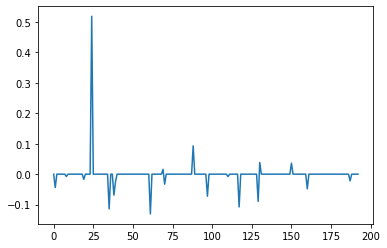

In [48]:
plt.plot(lasso_model.coef_[1])

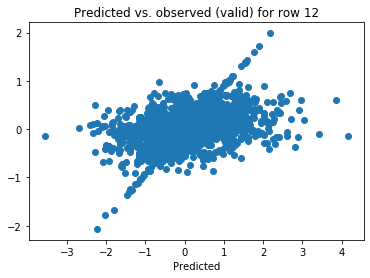

In [57]:
# plot predicted vs. observed for a random row
idx = np.random.randint(0, valid.shape[0])
plt.scatter(valid[idx], Y_hat[idx])
plt.xlabel("Observed")
plt.xlabel("Predicted")
plt.title("Predicted vs. observed (valid) for row {}".format(idx));

### Validation error

In [54]:
Y_hat = lasso_model.predict(valid[:, X_idx])
print(mean_squared_error(Y_hat, valid))

0.7631624239903559


### Test error

In [51]:
Y_hat = lasso_model.predict(test[:, X_idx])
print(mean_squared_error(Y_hat, test))

0.8251443901037103


### Let's try excluding the inputs from the outputs 

In [ ]:
alphas = np.linspace(0.001, 0.06, num=20)
valid_losses = []
for alpha in alphas:
    print("Computing validation loss for alpha = {}".format(alpha))
    lasso_model = Lasso(alpha).fit(train[:, X_idx], train[:, not_X])
    Y_hat = lasso_model.predict(valid[:, X_idx])
    valid_losses.append(mean_squared_error(Y_hat, valid[:, not_X]))

In [ ]:
# plot losses
plt.plot(alphas, valid_losses)
plt.title("Loss by alpha")
plt.show()

In [ ]:
print("Create a lasso model using alpha = {}".format(alphas[np.argmin(valid_losses)]))
lasso_model = Lasso(alphas[np.argmin(valid_losses)]).fit(train[:, X_idx], train)

In [ ]:
plt.plot(lasso_model.coef_[1])

In [ ]:
Y_hat = lasso_model_2.predict(valid[:, X_idx[0]].reshape(valid.shape[0],1))
print(mean_squared_error(Y_hat, valid))
plt.scatter(valid[3], Y_hat[3]);

### Is Y compressible?

In [58]:
pca_model = PCA().fit(train)

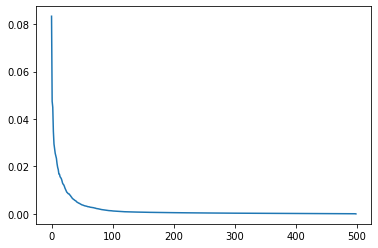

In [59]:
plt.plot(pca_model.explained_variance_ratio_)

In [60]:
# sanity check
sum(pca_model.explained_variance_ratio_)

0.9999999999999984